In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) >= 2 , "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cpu
torchvision version: 0.17.1+cpu


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    %git clone https://github.com/mrdbourke/pytorch-deep-learning
    %mv pytorch-deep-learning/going_modular/going_modular .
    %mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    %rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

C:\Users\vilem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%ls going_modular
device = "cuda" if torch.cuda.is_available() else "cpu"


 O volume na unidade C � SSD1
 O N�mero de S�rie do Volume � 44A7-BBAD

 Pasta de c:\Users\vilem\Desktop\IC\Udemy-Pytorch\going_modular

24/02/2024  12:12    <DIR>          .
26/02/2024  14:22    <DIR>          ..
24/02/2024  12:14    <DIR>          __pycache__
21/02/2024  11:09             2.167 data_setup.py
21/02/2024  11:09             7.204 engine.py
21/02/2024  11:09             2.492 model_builder.py
24/02/2024  12:14             1.652 pred_and_plot_image.py
22/02/2024  13:23             3.079 predictions.py
24/02/2024  12:12             2.464 train.py
21/02/2024  11:09             1.234 utils.py
               7 arquivo(s)         20.292 bytes
               3 pasta(s)   73.045.102.592 bytes dispon�veis


In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20_percent")

train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [5]:
import torchvision

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# effnetb2 = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)



for param in effnetb2.parameters():
    param.requires_grad = False

In [6]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True))

In [7]:
def create_effnetb2_model(num_classes:int=3,
                            seed:int=42):

    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

    transforms = effnetb2_weights.transforms()

    model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

    # from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
    # from torchvision.models._api import WeightsEnum
    # from torch.hub import load_state_dict_from_url

    # def get_state_dict(self, *args, **kwargs):
    #     kwargs.pop("check_hash")
    #     return load_state_dict_from_url(self.url, *args, **kwargs)
    # WeightsEnum.get_state_dict = get_state_dict

    # model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [8]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                    seed=42)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [13]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                test_dir=test_dir,
                                                                                                transform=effnetb2_transforms,
                                                                                                batch_size=32)

In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [81]:
from going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                                lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2800 | train_acc: 0.9292 | test_loss: 0.2777 | test_acc: 0.9812
Epoch: 2 | train_loss: 0.2583 | train_acc: 0.9333 | test_loss: 0.2699 | test_acc: 0.9568
Epoch: 3 | train_loss: 0.2467 | train_acc: 0.9479 | test_loss: 0.2457 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.2055 | train_acc: 0.9521 | test_loss: 0.2470 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.2092 | train_acc: 0.9542 | test_loss: 0.2413 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.2686 | train_acc: 0.9333 | test_loss: 0.2274 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.2536 | train_acc: 0.9146 | test_loss: 0.2179 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.2417 | train_acc: 0.9313 | test_loss: 0.2523 | test_acc: 0.9165
Epoch: 9 | train_loss: 0.2466 | train_acc: 0.9271 | test_loss: 0.2340 | test_acc: 0.9227
Epoch: 10 | train_loss: 0.2744 | train_acc: 0.8833 | test_loss: 0.2038 | test_acc: 0.9688


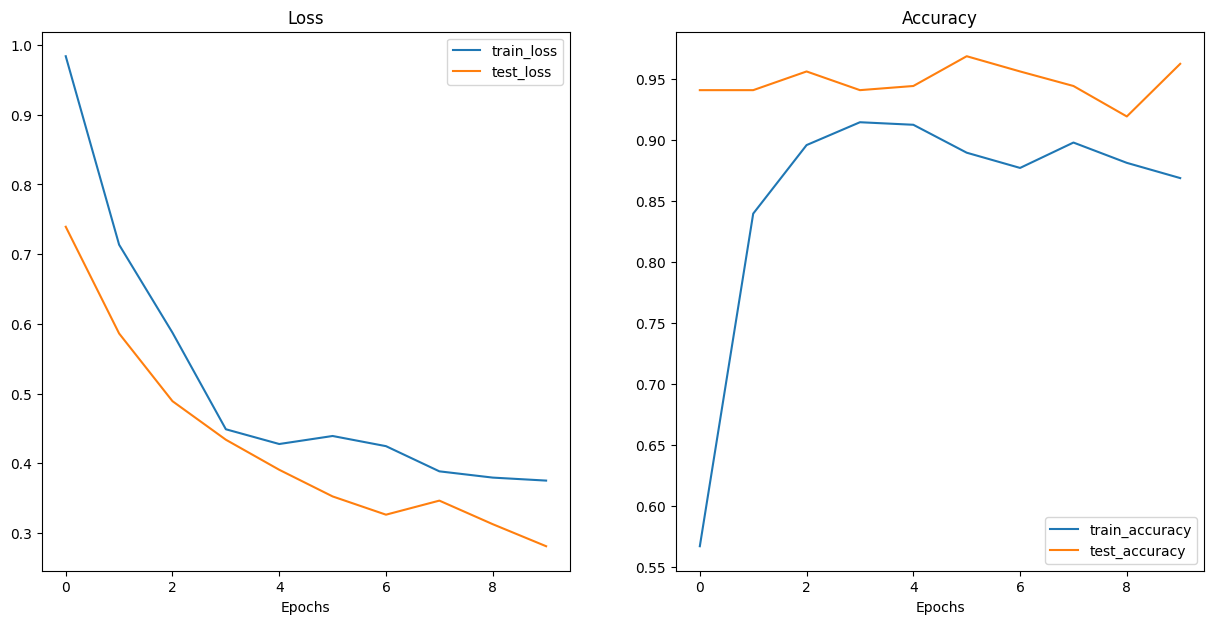

In [66]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [83]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [9]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [10]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


In [71]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

In [11]:
vit = torchvision.models.vit_b_16()
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [12]:
def create_vit_model(num_classes:int=3,
                      seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
      param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))

    return model, transforms

In [13]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [79]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1032 | train_acc: 0.9563 | test_loss: 0.0633 | test_acc: 0.9722
Epoch: 2 | train_loss: 0.0444 | train_acc: 0.9979 | test_loss: 0.0734 | test_acc: 0.9722
Epoch: 3 | train_loss: 0.0399 | train_acc: 1.0000 | test_loss: 0.0662 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.0292 | train_acc: 1.0000 | test_loss: 0.0594 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.0258 | train_acc: 1.0000 | test_loss: 0.0569 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0288 | train_acc: 1.0000 | test_loss: 0.0551 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0211 | train_acc: 1.0000 | test_loss: 0.0581 | test_acc: 0.9659
Epoch: 8 | train_loss: 0.0195 | train_acc: 1.0000 | test_loss: 0.0566 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0223 | train_acc: 1.0000 | test_loss: 0.0548 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0154 | train_acc: 1.0000 | test_loss: 0.0515 | test_acc: 0.9812


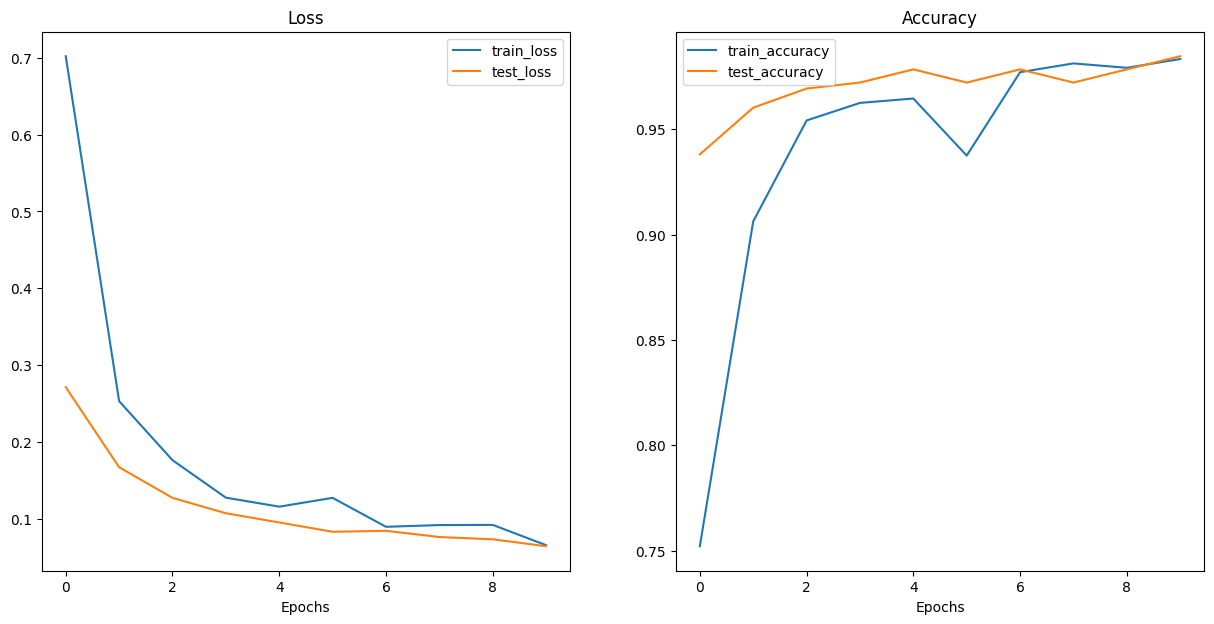

In [26]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [80]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")


[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [28]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327.37096977233887 MB


In [29]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
# print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

vit_total_params = sum(torch.numel(param) for param in vit.parameters())

vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}


In [30]:
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887}

In [19]:
from pathlib import Path

effnetb2, effnetb2_transorms = create_effnetb2_model()

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)

MODEL_NAME = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=effnetb2.state_dict(),
#             f=MODEL_SAVE_PATH)

effnetb2.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=torch.device('cpu')))

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# /content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
# /content/models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [27]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

Creating a function to make across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [28]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                    model:torch.nn.Module,
                    transform:torchvision.transforms,
                    class_names: List[str],
                    device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  pred_list = []

  for path in tqdm(paths):
    pred_dict = {}

    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    start_time = timer()

    img = Image.open(path)

    transformed_image = transform(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    pred_dict["correct"] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list


In [29]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                            model=effnetb2,
                                            transform=effnetb2_transforms,
                                            class_names=class_names,
                                            device="cpu")

100%|██████████| 150/150 [00:22<00:00,  6.59it/s]


In [35]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9829,
  'pred_class': 'pizza',
  'time_for_pred': 0.248,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.567,
  'pred_class': 'pizza',
  'time_for_pred': 0.0995,
  'correct': True}]

In [60]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9994,pizza,0.1741,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4835,pizza,0.1320,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9990,pizza,0.1299,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.8135,pizza,0.1357,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.8822,pizza,0.1364,True


In [61]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [38]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.0988


In [39]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.0988}

In [33]:
from pathlib import Path

vit, vit_transforms = create_vit_model()

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                        exist_ok=True)

MODEL_NAME = "09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=effnetb2.state_dict(),
#             f=MODEL_SAVE_PATH)

vit.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=torch.device('cpu')))

summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# /content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
# /content/models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [34]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                        model=vit,
                                        transform=vit_transforms,
                                        class_names=class_names,
                                        device="cpu")

100%|██████████| 150/150 [01:14<00:00,  2.00it/s]


In [41]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9986,
  'pred_class': 'pizza',
  'time_for_pred': 0.5681,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9968,
  'pred_class': 'pizza',
  'time_for_pred': 0.3968,
  'correct': True}]

In [58]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.3895,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.2837,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.2862,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.2715,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.2912,True


In [59]:
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [44]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.4419


In [45]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.4419}

In [46]:
df = pd.DataFrame([effnetb2_stats, vit_stats])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863886,0.0988,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.4419,ViT


In [47]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T



,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,10.962102,4.472672


In [48]:
import matplotlib
matplotlib.__version__

'3.7.1'

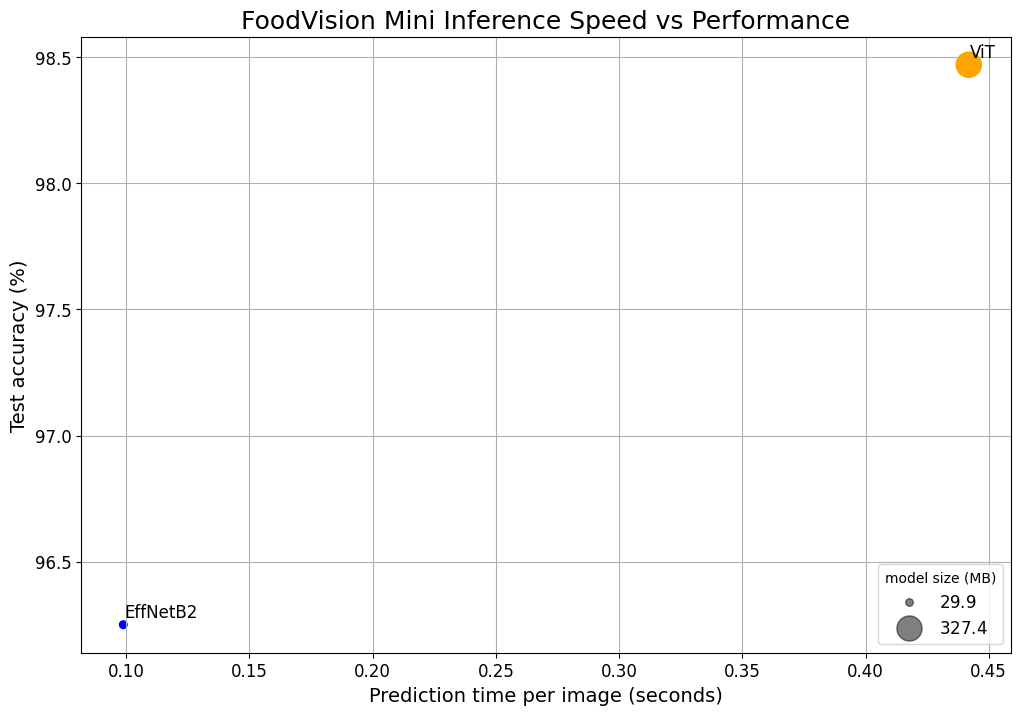

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                      x="time_per_pred_cpu",
                      y="test_acc",
                      c=["blue", "orange"],
                      s="model_size (MB)")

ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
              size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_sizze_legend = ax.legend(handles,
                               labels,
                               loc="lower right",
                               title="model size (MB)",
                               fontsize=12)

plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")


In [50]:
!nvidia-smi

Mon Feb 26 16:38:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  70W |   1101MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
try:
    import gradio as gr
except:
    %pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 4.19.2


In [38]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [39]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():

    pred_probs = torch.softmax(effnetb2(img), dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

In [40]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data\pizza_steak_sushi_20_percent\test\pizza\1001116.jpg
[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\pizza\930553.jpg



{'pizza': 0.9791454076766968, 'steak': 0.007580253295600414, 'sushi': 0.013274400494992733}
0.3182


In [41]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\2353677.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\413497.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\pizza\\2901001.jpg']]

In [ ]:
import gradio as gr

title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

In [43]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

!ls demos/foodvision_mini/

'ls' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [44]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


In [45]:
import os

example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [46]:
import shutil

effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f"[INFO] Model move complete.")
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [47]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [48]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms perparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                              gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [49]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt
